# Break High of Day (BHOD) Strategy Event-Driven Backtesting
In this notebook, we perform event-driven backtesting using the backtesting.py library. We will specifically focus on the Break High of Day (BHOD) strategy, as it's relatively simple to understand and implement, and we believe it has a high success rate. Furthermore, we believe that we can use this backtesting method to fine-tune the BHOD strategy even further, as we can alter different parameters of the strategy and see how it would have performed with historical data. Once we find the optimal parameters, we ultimately hope to test this strategy in the stock market to see how well it can do.

The following code shows the latest version of these backtests before we move on to vectorized backtesting.

## Importing Packages

In [2]:
from backtesting import Backtest, Strategy
from backtesting.backtesting import Order, Position, Trade, _Broker
from backtesting.test import GOOG
from backtesting.lib import crossover

import tulipy as ti

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
import time
import dask
import dask.dataframe as dd
from dask import delayed

import os
import sys

## Data Transformation / Cleaning Functions
These functions will be used to clean our data for us to use later on.

In [3]:
# Function for converting timestamp and setting it as index
def get_true_timestamp_and_set_as_index(pd_csv_ticker_1min):
    # Converting timestamp to actual timestamp
    pd_csv_ticker_1min['timestamp'] = pd.to_datetime(pd_csv_ticker_1min['timestamp'])
    
    # Setting the index to the timestamp
    pd_csv_ticker_1min.set_index('timestamp', inplace=True)

    return pd_csv_ticker_1min

In [4]:
# Function for filling in missing minutes
def fill_missing_minutes(index_timestamp_1_min, keep_only_PM_to_TD = False, PM_cutoff_time ='04:00'):
    index_timestamp_1_min = index_timestamp_1_min.resample('min').asfreq()

    # Filling in NaN values (volume with 0 and close to the last known close)
    index_timestamp_1_min['volume'] = index_timestamp_1_min['volume'].fillna(0);
    index_timestamp_1_min['close'] = index_timestamp_1_min['close'].ffill();
    
    # Filling in the rest, with the NaN being equal to the previous close
    index_timestamp_1_min['open'] = index_timestamp_1_min['open'].fillna(index_timestamp_1_min['close']);
    index_timestamp_1_min['high'] = index_timestamp_1_min['high'].fillna(index_timestamp_1_min['close']);
    index_timestamp_1_min['low'] = index_timestamp_1_min['low'].fillna(index_timestamp_1_min['close']);
    
    # Making sure there are only weekdays
    index_timestamp_1_min = index_timestamp_1_min[index_timestamp_1_min.index.weekday < 5]

    # Keeping only data from PM_cutoff_time to 3:59pm (if keep_only_PM_to_TD is True)
    if keep_only_PM_to_TD:
        index_timestamp_1_min = index_timestamp_1_min.between_time(PM_cutoff_time, '15:59')

    return index_timestamp_1_min

In [5]:
# Renaming columns with uppercase
def upper_case_OHLCV(no_missing_1_min):
    no_missing_1_min.rename(columns = {'open':'Open', 'high':'High', 'low':'Low', 'close':'Close', 'volume':'Volume'}, inplace = True)

    return no_missing_1_min

## Getting in Initial Data for MSFT
We use a small sample of MSFT data to test our backtesting framework.

In [7]:
# Loading in csv file data
MSFT_1min_sample_path = '../../../frd_stock_sample/MSFT_1min_sample.csv'
MSFT_1min = pd.read_csv(MSFT_1min_sample_path)

MSFT_1min = get_true_timestamp_and_set_as_index(MSFT_1min)
MSFT_1min = fill_missing_minutes(MSFT_1min, True)
MSFT_1min = upper_case_OHLCV(MSFT_1min)

## BHOD_Full_v1 Strategy
We create the full BHOD strategy class here with the framework from Backtesting.py. The backtesting process relies on sequential OHLCV 1-minute data with the timestamp as the index, and we showcase a run of this test below. If you're unfamiliar with the Break High of Day strategy itself, there are YouTube videos and other websites (e.g., Bear Bull Traders) that explain the strategy extensively. For a simplified summary, the strategy involves checking when the price of a stock breaks its previous high of the day, and after confirming a series of conditions, enters a long trade. To exit a trade, one of three conditions must be met: 1) at least the high of a 1-minute candlestick (CS) reaches a desired take-profit (TP) level, 2) at least the low of a 1-minute CS reaches the stop loss (SL) or breakeven point (BE), or 3) we reach 3:55pm with neither previous condition being met. In all cases above, we only trade during the regular trading hours, and we never hold overnight positions.

For this backtest, we implement the concepts explained above (and other concepts that are explained in the BHOD_Full_v1 class itself), and we can see our results from running this backtest below.

In [16]:
# With optimistic strategy (if sl hits with 1st tp, still get out, but assume that tp hits before be, so you still get profit)
class BHOD_Full_v1(Strategy):
    
    # Defining user inputs for volume, skipping opening range, bid-ask spread, and R
    use_volume_condition = True 
    set_volume_percent = 10  # Reset it back to 30% for default
    set_volume_avg_period = 14
    skip_opening_range = True
    minutes_skipped = 5
    BA_spread = 0.06  # Bid-ask spread manual input (default is 6 cents)
    risk_per_trade_R = 20  # Amount of money to risk per trade (default is $20)
    max_trade_amount = 50_000  # Maximum amount of money to use on a trade

    # R:R-based TP
    use_1st_RR_tp = True
    set_1st_R_partial = 1
    set_1st_R_percent = 25
    use_2nd_RR_tp = True
    set_2nd_R_partial = 2
    set_2nd_R_percent = 25
    use_3rd_RR_tp = True
    set_3rd_R_partial = 3
    set_3rd_R_percent = 50
    use_4th_RR_tp = False
    set_4th_R_partial = 4
    set_4th_R_percent = 0

    # Defining when to move SL
    move_SL_after_1st_tp = True
    move_SL_after_2nd_tp = False
    move_SL_after_3rd_tp = False

    
    def init(self):
        
        # Calculate average volume over last XX candlesticks
        # self.avg_volume = self.I(talib.SMA, self.data.Volume, self.set_volume_avg_period)  # This makes self.avg_volume and indicator that will
        # dynamically update in the next method (Do not delete even if using tulipy, will be useful for later)

        # If using tulipy for SMA instead:
        def tulipy_sma(data, period):

            # Calculate the SMA using tulipy
            sma_result = ti.sma(np.asarray(data), period)
            
            # Pad the result with NaNs to align with the input length
            nan_padding = np.full(period - 1, np.nan)
            
            return np.concatenate((nan_padding, sma_result))

        self.avg_volume = self.I(tulipy_sma, self.data.Volume, self.set_volume_avg_period)

        
        # Adding in volume condition (if applied)
        if self.use_volume_condition: # This adds the multiplier to self.avg_volume
            self.avg_volume = np.round(self.avg_volume * (1 + (self.set_volume_percent / 100)), decimals = 0)
        else: # Rounding to nearest whole number
            self.avg_volume = np.round(self.avg_volume, decimals = 0)

        # Getting timestamps as a series to manage day resets
        times = self.data.index

        # Calculate numpy array to store whether the high of each CS broke the HOD for each day
        len_data = len(self.data)  # Getting length of data
        self.HOD_array = np.zeros(len_data)  # Array for storing HOD
        self.prev_HOD_array = np.zeros(len_data + 1)  # Array for storing previous HOD
        self.prev_HOD_array[0] = 0  # Initializing first element of prev_HOD_array with 0

        # Initializing HOD_price and prev_HOD_price
        HOD_price = 0  # Current HOD including this CS
        prev_HOD_price = 0  # HOD excluding the current CS

        for i in range(len_data):
            # Reset the HOD at 9:30am each day
            if times[i].time() == pd.to_datetime('09:30').time():
                HOD_price = self.data.High[i]  # Reset the HOD to the open high of 9:30am candle

            # Update the HOD for the current day
            if self.data.High[i] > HOD_price:
                HOD_price = self.data.High[i]  # Update the high of the day

            # Store the HOD value for each point in the array
            self.HOD_array[i] = HOD_price

            # Store the HOD value for the next minute in the prev_HOD_array array
            self.prev_HOD_array[i + 1] = HOD_price

        # Removing the last element in prev_HOD_array to get the same length array as HOD_array 
        self.prev_HOD_array_view = self.prev_HOD_array[:-1]

        # Making both HOD_array and prev_HOD_array_view indicators (this part is EXTREMELY NECESSARY: the next method will only run an array dynamically
        # when it's either 1) an OHLCV field or 2) an indicator. By wrapping our pre-conceived np arrays in self.I(), we will create these indicators).
        self.HOD_indicator = self.I(lambda: self.HOD_array)
        self.prev_HOD_I = self.I(lambda: self.prev_HOD_array_view)
        
        # Create arrays for time conditions (true for times within __:__ to 15:55)
        self.start_time = pd.to_datetime('09:30').time()
        if self.skip_opening_range:
            self.start_time = (pd.to_datetime('09:30') + pd.Timedelta(minutes = self.minutes_skipped)).time()
        
        self.valid_trading_times = (self.start_time <= times.time) & (times.time <= pd.to_datetime('15:55').time())
        self.valid_trading_times_I = self.I(lambda: self.valid_trading_times)  # Turning valid_trading_times into indicator for next(self) method
    
        # Initializing (pre-sets) variables to only be changed in next(self) method when certain conditions are met.
        # Generally, this means that the variables will stay the same and not be in use until the position is opened, whereby it changes (and stays) at that new number:
        
        # Initializing previous midpoint, SL (stop loss), BE (breakeven), and entry with BA-spread
        self.previous_midpoint = None
        self.BHOD_SL = None
        self.BHOD_BE = None
        self.entry_w_slippage = None

        # Initializing dynamic shares calculation:
        self.dynamic_shares_total = None
        self.dynamic_1st_R_shares = None
        self.dynamic_2nd_R_shares = None
        self.dynamic_3rd_R_shares = None
        self.dynamic_4th_R_shares = None
        
        # Setting the TP_Long_XXX_R_price to None (to be changed when XXX take profit R-level is met)
        self.TP_Long_1st_R_price = None
        self.TP_Long_2nd_R_price = None
        self.TP_Long_3rd_R_price = None
        self.TP_Long_4th_R_price = None

        # Setting condition for 1st entry candle
        self.entry_CS = False
        
        # Setting checks for when positions are fulfilled so it doesn't repeat:
        self.check_SL = False
        self.check_BE = False
        self.check_1st_TP = False
        self.check_2nd_TP = False
        self.check_3rd_TP = False
        self.check_4th_TP = False

        # Defining entry price (necessary for backtesting purposes (see below in next(self) method)
        self.entry_price_stored = None

        # Defining BHOD_entry_correction (necessary for backtesting purposes (see below in next(self) method)
        self.BHOD_entry_correction = False

        # For testing purposes:
        self.start_time = None
        self.end_time = None


    
    def next(self):

        # if self.data.index[-1] == pd.to_datetime('2024-07-22 04:00:00'):
        #     print(self.data.index[-1])
        #     self.start_time = time.time()

        # If there are no positions open, then reset all the checks to False (more important below when doing SL, BE, and TP):
        if not self.position:
            self.check_SL = False
            self.check_BE = False
            self.check_1st_TP = False
            self.check_2nd_TP = False
            self.check_3rd_TP = False
            self.check_4th_TP = False

        # Resetting entry CS to False (will be turned on later)
        self.entry_CS = False
    

        # Valid trading time condition (if not valid, then skip this CS)
        if not self.valid_trading_times_I[-1]:
            return

        # Updated volume condition (so BHOD buy method can trigger when met):
        final_volume_condition = not self.use_volume_condition or self.data.Volume[-1] >= self.avg_volume[-1]

        # Creating condition for breaking previous HOD and condition for non-continuous HOD break
        broke_prev_HOD_cond = self.data.High[-1] > self.prev_HOD_I[-1]
        non_continuous_BHOD = self.data.High[-2] <= self.prev_HOD_I[-2] and self.data.High[-3] <= self.prev_HOD_I[-3]

        # Confirming conditions for long entry, and then entering long
        if broke_prev_HOD_cond and non_continuous_BHOD and final_volume_condition and not self.position:  # self.position checks if there's a position out there
            # Defining previous candlestick midpoint
            self.previous_midpoint = (self.data.Open[-2] + self.data.Close[-2]) / 2

            # For BHOD, set SL at the lower of the current CS low or halfway between open and close of previous CS
            self.BHOD_SL = min(self.previous_midpoint, self.data.Low[-1])

            # Including BA-spread slippage in price (min of (0.5 * BA_spread + prev HOD) and current CS high (to make sure we're still w/in the CS)):
            self.entry_w_slippage = min(self.prev_HOD_I[-1] + self.BA_spread / 2, self.data.High[-1]) 

            # Setting dynamic share size (need to wrap in int for self.position to work (because self.position.size needs to be int)):
            self.dynamic_shares_total = int(np.floor(self.risk_per_trade_R / (self.entry_w_slippage - self.BHOD_SL)))

            # If the total amount used (entry amount * share size) is larger than a set value, skip this CS
            if self.entry_w_slippage * self.dynamic_shares_total > self.max_trade_amount:
                return
            
            # Entry long (need to set sl and tp to None b/c they both trigger on next CS open price (i.e., they're not exact))
            self._broker._open_trade(price = self.entry_w_slippage,
                                     size = self.dynamic_shares_total, sl = None, tp = None, time_index = len(self.data)-1)

            # Setting condition for first entry candle to True:
            self.entry_CS = True
            
            # Setting self.check_SL and self.check_1st_TP to true so their conditions can be activated (down below):
            self.check_SL = True
            self.check_1st_TP = True

            # Store the entry price when position is opened
            self.entry_price_stored = self.trades[0].entry_price  # trades is a tuple, so need to access first element in tuple first to get entry_price

            # Setting take profit prices
            self.TP_Long_1st_R_price = (self.entry_price_stored - self.BHOD_SL) * self.set_1st_R_partial + self.entry_price_stored
            self.TP_Long_2nd_R_price = (self.entry_price_stored - self.BHOD_SL) * self.set_2nd_R_partial + self.entry_price_stored
            self.TP_Long_3rd_R_price = (self.entry_price_stored - self.BHOD_SL) * self.set_3rd_R_partial + self.entry_price_stored
            self.TP_Long_4th_R_price = (self.entry_price_stored - self.BHOD_SL) * self.set_4th_R_partial + self.entry_price_stored

            # Setting take profit share sizes
            if self.use_1st_RR_tp:
                self.dynamic_1st_R_shares = int(np.floor(self.dynamic_shares_total * self.set_1st_R_percent / 100))
            # 2R is basically taking the remaining shares after 1st R and calculating 2nd R share size from that (instead of doing it all at once in the beginning)
            if self.use_2nd_RR_tp:
                self.dynamic_2nd_R_shares = int(np.floor(
                    (self.dynamic_shares_total - self.dynamic_1st_R_shares) * self.set_2nd_R_percent / (100 - self.set_1st_R_percent)))
            # 3R follows suit
            if self.use_3rd_RR_tp:
                self.dynamic_3rd_R_shares = int(np.floor(
                    (self.dynamic_shares_total - self.dynamic_1st_R_shares - self.dynamic_2nd_R_shares) * 
                    self.set_3rd_R_percent / (100 - self.set_1st_R_percent - self.set_2nd_R_percent)))
            # 4R follows suit as well (if applied)
            if self.use_4th_RR_tp:
                self.dynamic_4th_R_shares = int(np.floor(
                    (self.dynamic_shares_total - self.dynamic_1st_R_shares - self.dynamic_2nd_R_shares - self.dynamic_3rd_R_shares) * 
                    self.set_4th_R_percent / (100 - self.set_1st_R_percent - self.set_2nd_R_percent - self.set_3rd_R_percent)))

        
        # If the position is open and the low of a CS falls below SL, close the position
        if self.position and self.check_SL and self.data.Low[-1] < self.BHOD_SL:
            self._broker._reduce_trade(self.trades[0], max(self.BHOD_SL - self.BA_spread / 2, self.data.Low[-1]),
                                       -1 * self.position.size, len(self.data)-1)  #  You'll always lose a little extra b/c of slippage
        
        # If SL is not hit and we're on the 1st R (self.check_1st_TP is True), check for tp; if the high hits tp level, partial a certain amount
        if self.position and self.use_1st_RR_tp and self.check_1st_TP and self.data.High[-1] >= self.TP_Long_1st_R_price:
            self._broker._reduce_trade(self.trades[0], self.TP_Long_1st_R_price, -1 * self.dynamic_1st_R_shares, len(self.data)-1)
            self.check_1st_TP = False
            self.check_2nd_TP = True
            self.BHOD_BE = self.entry_price_stored  # Set the BE amount to the entry price

            # If SL should be moved after 1st tp (move_SL_after_1st_tp = True), move SL to breakeven; if not, maintain SL
            if self.move_SL_after_1st_tp:
                self.check_SL = False
                self.check_BE = True

        # Note: don't need to include bid-ask spread for take profit because you will ONLY sell at that tp price (or better)

        # If 1st tp is successful, set the check to be the 2nd tp, and partial that amount
        if self.position and self.use_2nd_RR_tp and self.check_2nd_TP and self.data.High[-1] >= self.TP_Long_2nd_R_price:
            self._broker._reduce_trade(self.trades[0], self.TP_Long_2nd_R_price, -1 * self.dynamic_2nd_R_shares, len(self.data)-1)
            self.check_2nd_TP = False
            self.check_3rd_TP = True

            # If SL should be moved after 2nd tp (move_SL_after_2nd_tp = True), move SL to breakeven; if not, maintain SL
            if self.move_SL_after_2nd_tp:
                self.check_SL = False
                self.check_BE = True

        # If 2nd tp is successful, set the check to be the 3rd tp, and partial that amount
        if self.position and self.use_3rd_RR_tp and self.check_3rd_TP and self.data.High[-1] >= self.TP_Long_3rd_R_price:
            self._broker._reduce_trade(self.trades[0], self.TP_Long_3rd_R_price, -1 * self.dynamic_3rd_R_shares, len(self.data)-1)
            self.check_3rd_TP = False
            self.check_4th_TP = True

            # If SL should be moved after 3rd tp (move_SL_after_3rd_tp = True), move SL to breakeven; if not, maintain SL
            if self.move_SL_after_3rd_tp:
                self.check_SL = False
                self.check_BE = True

        # If 3rd tp is successful, set the check to be the 4th tp, and partial that amount (if applied)
        if self.position and self.use_4th_RR_tp and self.check_4th_TP and self.data.High[-1] >= self.TP_Long_4th_R_price:
            self._broker._reduce_trade(self.trades[0], self.TP_Long_4th_R_price, -1 * self.dynamic_4th_R_shares, len(self.data)-1)
            self.check_4th_TP = False

        # If BE (breakeven) is hit (not on the 1st (entry) CS), close the position (optimistic because it goes last)
        if self.position and self.check_BE and not self.entry_CS and self.data.Low[-1] < self.BHOD_BE:
            self._broker._reduce_trade(self.trades[0], max(self.BHOD_BE - self.BA_spread / 2, self.data.Low[-1]),
                                       -1 * self.position.size, len(self.data)-1)  # Even at BE, slippage will cause you to lose a bit more

        # Closing all orders and positions at 3:55pm
        if self.data.index.time[-1] == pd.to_datetime('15:55').time():

            # Cancel all open orders
            for order in self.orders:
                order.cancel()

            # Close any open positions
            if self.position:
                self._broker._reduce_trade(self.trades[0], self.data.Close[-1], -1 * self.position.size, len(self.data)-1)
            
        # if self.data.index[-1] == pd.to_datetime('2024-07-22 15:54:00'):
        #     print(self.data.index[-1])
        #     self.end_time = time.time()
        #     print(self.end_time - self.start_time)

# Backtesting.py doc code
# https://github.com/kernc/backtesting.py/blob/master/backtesting/backtesting.py

## MSFT_1min Testing
We initialize the backtest using Backtest(), and then we run that instance using .run(). This will sequentially go through all the data, and we can use ._trades to output every trade that the backtest took, along with some details about that trade.

In [10]:
# Running some test trades
bt_test = Backtest(MSFT_1min, BHOD_Full_v1, cash = 100_000, commission = 0.002)

run_test = bt_test.run()
# run_test = bt_test.run(use_volume_condition = True, move_SL_after_1st_tp = False, move_SL_after_2nd_tp = True)
# run_test = bt_test.run(use_volume_condition = True, set_1st_R_percent = 100, use_2nd_RR_tp = False, use_3rd_RR_tp = False)
# run_test = bt_test.run(use_volume_condition = True, set_1st_R_percent = 50, set_2nd_R_percent = 50, use_3rd_RR_tp = False)
run_test._trades

,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,PnL,ReturnPct,EntryTime,ExitTime,Duration
0,9,421,433,456.28,456.79335,4.62015,0.001125,2024-07-15 11:01:00,2024-07-15 11:13:00,0 days 00:12:00
1,29,421,446,456.28,456.25000,-0.87000,-0.000066,2024-07-15 11:01:00,2024-07-15 11:26:00,0 days 00:25:00
2,25,2060,2061,444.38,444.57600,4.90000,0.000441,2024-07-17 14:20:00,2024-07-17 14:21:00,0 days 00:01:00
3,77,2060,2062,444.38,444.35000,-2.31000,-0.000068,2024-07-17 14:20:00,2024-07-17 14:22:00,0 days 00:02:00
4,62,2123,2126,444.70,444.35250,-21.54500,-0.000781,2024-07-17 15:23:00,2024-07-17 15:26:00,0 days 00:03:00
5,7,3995,4000,443.93,444.59500,4.65500,0.001498,2024-07-22 10:35:00,2024-07-22 10:40:00,0 days 00:05:00
6,23,3995,4004,443.93,443.90000,-0.69000,-0.000068,2024-07-22 10:35:00,2024-07-22 10:44:00,0 days 00:09:00
7,8,4658,4660,444.47,445.07000,4.80000,0.001350,2024-07-23 09:38:00,2024-07-23 09:40:00,0 days 00:02:00
8,8,4658,4660,444.47,445.67000,9.60000,0.002700,2024-07-23 09:38:00,2024-07-23 09:40:00,0 days 00:02:00
9,17,4658,4662,444.47,446.27000,30.60000,0.004050,2024-07-23 09:38:00,2024-07-23 09:42:00,0 days 00:04:00


We no longer use the following chart visualization feature as we now have other ways of viewing the data. However, we keep this visualization in here to showcase one of the days that the BHOD strategy may have executed on.

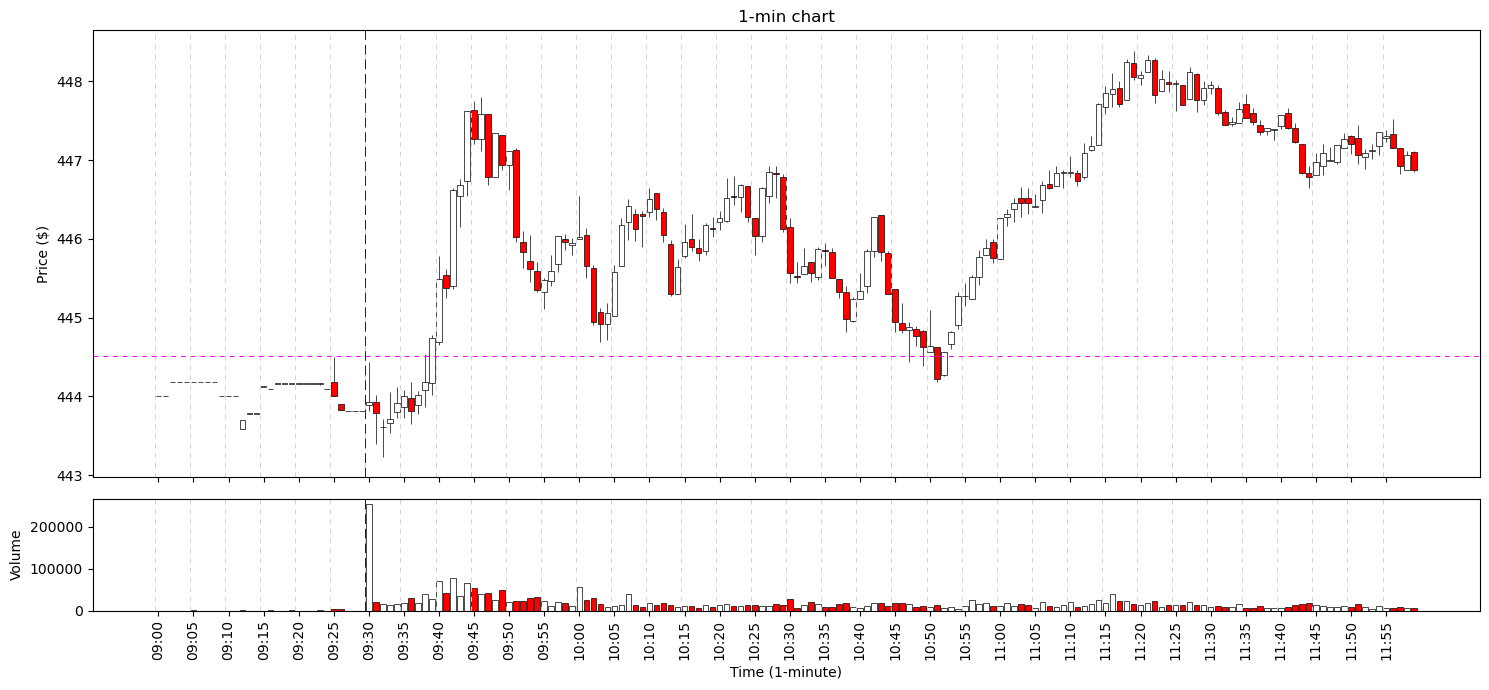

In [14]:
# Getting chart visualization for a particular date
date_in_str = '2024-07-23'
get_chart_visual(MSFT_1min_for_chart, True, date_in_str, 300, 480)

# Using Dask Dataframes to run parallelize our backtest
Dask allows us to expedite each backtest by parallelizing the process of running through all the data with our framework.

## Delayed function for partitioning
We create this delayed function so we can compute (i.e., execute) the backtest when we're ready.

In [11]:
# Defining a delayed function that basically doesn't compute until dask.compute() is run (which allows the parallel running to execute)
@delayed
def run_backtest_on_partition(data_partition, strategy_class, cash=100_000):
    
    if data_partition.empty:  # Skip if the partition is on the weekend or holiday (and thus will have empty data)
        return None
        
    bt_test = Backtest(data_partition, strategy_class, cash=cash)  # Defining backtest
    result = bt_test.run()._trades  # Running backtest (but not yet, and will only run when dask.compute() is called)
    # *Note, we're only taking the trades and calculating everything from that afterward

    return result

## Loading MSFT 3y, TSLA 3y, and TSLA 10y 9am-3:59pm poly data
We obtained 1-minute data from the Polygon.io API, and we cleaned the data in a previous notebook. We're now simply retrieving that data (located in an outside folder) and creating partitions for dask. Afterward, we repartition the data so that each partition holds 1 day worth of candlesticks. We could also have changed the frequency to hold more, but the speed increase from larger partitions is canceled out by the larger np arrays that need to be created from the Backtesting.py class.

In [13]:
# Loading in MSFT 3y data and parsing timestamp, and then setting timestamp as index
MSFT_1min_poly_3y_9am_4pm = dd.read_csv('../../../MSFT_1min_poly_3y_9am_4pm.csv', parse_dates=['timestamp'])
MSFT_1min_poly_3y_9am_4pm = MSFT_1min_poly_3y_9am_4pm.set_index('timestamp')

# Repartitioning so that each partition holds one day's worth of data (it does include weekends, but not a big deal)
MSFT_1min_poly_3y_9am_4pm = MSFT_1min_poly_3y_9am_4pm.repartition(freq='1D')

In [14]:
# Loading in TSLA 3y data and parsing timestamp, and then setting timestamp as index
TSLA_1min_poly_3y_9am_4pm = dd.read_csv('../../../TSLA_1min_poly_3y_9am_4pm.csv', parse_dates=['timestamp'])
TSLA_1min_poly_3y_9am_4pm = TSLA_1min_poly_3y_9am_4pm.set_index('timestamp')

# Repartitioning into frequency of 1 day
TSLA_1min_poly_3y_9am_4pm = TSLA_1min_poly_3y_9am_4pm.repartition(freq='1D')

In [15]:
# Loading in TSLA 10y data and parsing timestamp, and then setting timestamp as index
TSLA_1min_poly_10y_9am_4pm = dd.read_csv('../../../TSLA_1min_poly_10y_9am_4pm.csv', parse_dates=['timestamp'])
TSLA_1min_poly_10y_9am_4pm = TSLA_1min_poly_10y_9am_4pm.set_index('timestamp')

# Repartitioning into frequency of 1 day
TSLA_1min_poly_10y_9am_4pm = TSLA_1min_poly_10y_9am_4pm.repartition(freq='1D')

## Running MSFT 3y, TSLA 3y, and TSLA 10y 9am-3:59pm poly data
We can now run through our backtest using dask dataframes. For 3 years of data, we will finish in roughly 70 seconds, and for 10 years of data, we will finish in roughly 230 seconds. We can then see our combined results, which lists all the trades that the backtest took.

In [17]:
start_time = time.time()
# Testing with the MSFT_1min_poly_3y_9am_4pm (dask df) for full test

# Apply the function to each partition and get delayed objects for each backtest
partitions_MSFT_3y_9am_4pm = MSFT_1min_poly_3y_9am_4pm.to_delayed()
bt_results_MSFT_3y_9am_4pm = [run_backtest_on_partition(partition, BHOD_Full_v1) for partition in partitions_MSFT_3y_9am_4pm]

# Compute all results
all_results_MSFT_3y_9am_4pm = dask.compute(*bt_results_MSFT_3y_9am_4pm)

# Combining the "results" dataframes into one dataframe using pd.concat
combined_results_MSFT_3y_9am_4pm = pd.concat(all_results_MSFT_3y_9am_4pm, axis=0).reset_index(drop = True)

print(time.time() - start_time)
# Final time was 1 minute 10 seconds (70 seconds)

67.34629607200623


/var/folders/7l/wmvnlgr934b3zwnq5s8bsrwm0000gn/T/ipykernel_67770/2804752159.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_results_MSFT_3y_9am_4pm = pd.concat(all_results_MSFT_3y_9am_4pm, axis=0).reset_index(drop = True)


In [18]:
start_time = time.time()
# Testing with the TSLA_1min_poly_3y_9am_4pm (dask df) for full test

# Apply the function to each partition and get delayed objects for each backtest
partitions_TSLA_3y_9am_4pm = TSLA_1min_poly_3y_9am_4pm.to_delayed()
bt_results_TSLA_3y_9am_4pm = [run_backtest_on_partition(partition, BHOD_Full_v1) for partition in partitions_TSLA_3y_9am_4pm]

# Compute all results
all_results_TSLA_3y_9am_4pm = dask.compute(*bt_results_TSLA_3y_9am_4pm)

# Combining the "results" dataframes into one dataframe using pd.concat
combined_results_TSLA_3y_9am_4pm = pd.concat(all_results_TSLA_3y_9am_4pm, axis=0).reset_index(drop = True)

print(time.time() - start_time)
# Final time was 1 minute 9 seconds (69 seconds)

66.32312870025635


/var/folders/7l/wmvnlgr934b3zwnq5s8bsrwm0000gn/T/ipykernel_67770/1582775885.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_results_TSLA_3y_9am_4pm = pd.concat(all_results_TSLA_3y_9am_4pm, axis=0).reset_index(drop = True)


In [19]:
start_time = time.time()
# Testing with the TSLA_1min_poly_10y_9am_4pm (dask df) for full test

# Apply the function to each partition and get delayed objects for each backtest
partitions_TSLA_10y_9am_4pm = TSLA_1min_poly_10y_9am_4pm.to_delayed()
bt_results_TSLA_10y_9am_4pm = [run_backtest_on_partition(partition, BHOD_Full_v1) for partition in partitions_TSLA_10y_9am_4pm]

# Compute all results
all_results_TSLA_10y_9am_4pm = dask.compute(*bt_results_TSLA_10y_9am_4pm)

# Combining the "results" dataframes into one dataframe using pd.concat
combined_results_TSLA_10y_9am_4pm = pd.concat(all_results_TSLA_10y_9am_4pm, axis=0).reset_index(drop = True)

print(time.time() - start_time)
# Final time was 3 minutes 50 seconds (230 seconds)

223.29137802124023


/var/folders/7l/wmvnlgr934b3zwnq5s8bsrwm0000gn/T/ipykernel_67770/1625094597.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_results_TSLA_10y_9am_4pm = pd.concat(all_results_TSLA_10y_9am_4pm, axis=0).reset_index(drop = True)


In [20]:
combined_results_TSLA_10y_9am_4pm

,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,PnL,ReturnPct,EntryTime,ExitTime,Duration
0,133.0,46.0,55.0,15.40,15.220,-23.940,-0.011688,2014-10-28 09:46:00,2014-10-28 09:55:00,0 days 00:09:00
1,90.0,67.0,70.0,15.43,15.485,4.950,0.003564,2014-10-28 10:07:00,2014-10-28 10:10:00,0 days 00:03:00
2,91.0,67.0,74.0,15.43,15.540,10.010,0.007129,2014-10-28 10:07:00,2014-10-28 10:14:00,0 days 00:07:00
3,182.0,67.0,82.0,15.43,15.595,30.030,0.010693,2014-10-28 10:07:00,2014-10-28 10:22:00,0 days 00:15:00
4,99.0,124.0,126.0,15.83,15.880,4.950,0.003159,2014-10-28 11:04:00,2014-10-28 11:06:00,0 days 00:02:00
...,...,...,...,...,...,...,...,...,...,...
9855,38.0,384.0,390.0,259.83,260.610,29.640,0.003002,2024-10-24 15:24:00,2024-10-24 15:30:00,0 days 00:06:00
9856,43.0,406.0,408.0,262.03,261.545,-20.855,-0.001851,2024-10-24 15:46:00,2024-10-24 15:48:00,0 days 00:02:00
9857,7.0,37.0,38.0,262.86,263.555,4.865,0.002644,2024-10-25 09:37:00,2024-10-25 09:38:00,0 days 00:01:00
9858,7.0,37.0,38.0,262.86,264.250,9.730,0.005288,2024-10-25 09:37:00,2024-10-25 09:38:00,0 days 00:01:00


## Data Analysis in Function Format
We now define a few functions to analyze our data.

In [21]:
# Defining function to produce data analysis results (trade_results need to come in the correct format (index goes from 0 to n))
def metrics_table(trade_results, strategy_name, starting_cash = 100_000, show_drawdown_plot = False):  

    # Getting the trade PnL for each full trade (not just partials)
    trade_pnl = trade_results.groupby('EntryTime')['PnL'].sum()  # Group by EntryTime (our "Trade ID") and sum PnL for each trade
    
    # Net profit
    net_profit = trade_results['PnL'].sum()

    # Profit factor
    pos_trades_dollar_total = trade_pnl[trade_pnl > 0].sum()
    neg_trades_dollar_total = trade_pnl[trade_pnl <= 0].sum()
    profit_factor = pos_trades_dollar_total / neg_trades_dollar_total * -1

    # Win ratio
    num_pos_trades = (trade_pnl > 0).sum()  # Count of full trades (not just partials) with positive PnL
    num_neg_trades = (trade_pnl <= 0).sum()
    num_trades_total = len(trade_pnl)  # Total number of trades
    win_ratio = num_pos_trades / num_trades_total
    
    # Profit/loss per winning/losing trade
    avg_winner_amount = trade_pnl[trade_pnl > 0].mean()
    avg_loser_amount = trade_pnl[trade_pnl <= 0].mean()

    # Risk:reward ratio
    rr_ratio = avg_loser_amount / avg_winner_amount * -1

    # Expected profitability
    loss_ratio = 1 - win_ratio
    expected_profitability = (win_ratio * avg_winner_amount) + (loss_ratio * avg_loser_amount)
    
    # Expected value (same result as expected profitability, but calculated differently)
    expected_value = net_profit / num_trades_total

    # Biggest winner / loser
    biggest_winner = round(max(trade_pnl), 3)
    biggest_loser = round(min(trade_pnl), 3)

    # Equity peak and trough
    cum_equity = trade_results['PnL'].cumsum()
    equity_peak = max(cum_equity)
    equity_trough = min(cum_equity)

    # Maximum winning and losing streaks:
    signs = trade_pnl.apply(lambda x: 1 if x > 0 else -1)  # Converting to binary indicators (1 for (+), -1 for (-) or (0))
    streaks = signs.groupby((signs != signs.shift()).cumsum())  # Identifying consecutive streaks using groupby and cumsum
    # Breaking the above code down: signs != signs.shift() gives True when the sign shifts, and cumsum() takes the sum of the Trues (1) and
    # Falses (0), so when the sign shifts (i.e., another True (i.e., 1)), it gives a different number, and it groups by those same numbers
    max_winning_streak = streaks.apply(lambda x: (x == 1).sum()).max()  # Applying a sum to the 1's in each group (streaks)
    max_losing_streak = streaks.apply(lambda x: (x == -1).sum()).max()  # Applying a sum to the -1's in each group (streaks)

    # Max drawdown
    cum_pnl_series = trade_pnl.cumsum() + starting_cash  # Getting the cumulative pnl as a series
    grouped_pnl_df = cum_pnl_series.to_frame(name = 'cum_pnl')  # Converting the cum_pnl_series to a df
    grouped_pnl_df['running_max'] = grouped_pnl_df['cum_pnl'].cummax()  # Getting the running maximum (the running peak of equity)
    grouped_pnl_df['drawdown'] = grouped_pnl_df['cum_pnl'] - grouped_pnl_df['running_max']  # Getting drawdown for each trade
    max_drawdown = grouped_pnl_df['drawdown'].min()  # Getting the max drawdown (most negative amount)
    max_drawdown_perc = (grouped_pnl_df['drawdown'] / grouped_pnl_df['running_max']).min() * 100  # Getting max drawdown as a percent

    # Max drawdown plot (if show_drawdown_plot set to True) 
    if show_drawdown_plot:
        # Plot cumulative PnL and running maximum
        plt.figure(figsize=(12, 6))
        plt.plot(grouped_pnl_df.index, grouped_pnl_df['cum_pnl'], label = 'Cumulative PnL', color = 'blue')
        plt.plot(grouped_pnl_df.index, grouped_pnl_df['running_max'], label = 'Running Max', color = 'green')
        
        # Plot the drawdown as an area (below the cumulative PnL)
        plt.fill_between(grouped_pnl_df.index, grouped_pnl_df['cum_pnl'], grouped_pnl_df['running_max'], 
                         where = (grouped_pnl_df['cum_pnl'] < grouped_pnl_df['running_max']),
                         color = 'red', alpha = 0.3, label = 'Drawdown')
        
        # Add titles and labels
        plt.title('Maximum Drawdown Visualization')
        plt.xlabel('Date')
        plt.ylabel('PnL')
        
        # Show the legend
        plt.legend()
        
        # Display the plot
        plt.show()

    # Making trade_pnl into a dataframe for deeper analyses
    full_trade_df = trade_pnl.to_frame(name = 'trade_pnl')

    # Average $ used for trade
    full_trade_df['total_trade_size'] = trade_results.groupby('EntryTime')['Size'].sum()
    full_trade_df['entry_amount'] = trade_results.groupby('EntryTime')['EntryPrice'].mean()
    full_trade_df['amount_used_for_trade'] = full_trade_df['total_trade_size'] * full_trade_df['entry_amount']
    avg_amount_used_for_trade = full_trade_df['amount_used_for_trade'].mean()
    
    # Maximum $ used for a trade
    max_amount_used_for_trade = full_trade_df['amount_used_for_trade'].max()

    # Average holding time (from entry to last exit (partial))
    last_holding_times = trade_results.groupby('EntryTime')['Duration'].nth(-1)  # Get the last Duration for each EntryTime
    average_holding_time = last_holding_times.mean().total_seconds() / 60  # Average holding time in minutes

    
    # Average holding time for each partial

    # Creating dataframe for partials analysis
    partials_df = trade_results[['EntryTime', 'Duration', 'PnL']].copy()

    # Assign a position (partial) number within each EntryTime
    partials_df['Trade_Position'] = trade_results.groupby('EntryTime').cumcount() + 1

    # Calculate mean holding time for each position (partial)
    avg_hold_time_by_position = partials_df.groupby('Trade_Position')['Duration'].mean()

    # Convert mean holding times to minutes
    avg_hold_time_by_pos_min = avg_hold_time_by_position.apply(lambda x: x.total_seconds() / 60)
    # This metric is not very useful to us, since it just takes every partial at a particular time and average it out
    
    # Average holding time for each partial number (making it so that we get the avg holding time depending on how many partials it took)
    # Get the last Duration for each EntryBar along with its position number:
    last_holding_times_w_pos = partials_df.groupby('EntryTime').apply(lambda x: x.iloc[-1])[['Duration', 'Trade_Position']]
    avg_hold_time_by_trade_num = last_holding_times_w_pos.groupby('Trade_Position')['Duration'].mean()
    avg_hold_time_by_trade_num_min = avg_hold_time_by_trade_num.apply(lambda x: x.total_seconds() / 60)
    # This might be interesting; in this current test, the time it takes to get out after you do your first partial (2) is actually less
    # than the time it takes to get out after your second partial (3) (10.2 min vs 6.4 min). This could indicate that after the first
    # partial, if it takes too long, it could be could to just get out before the price drops to breakeven (could be worth doing more
    # analysis to see when drop happens).

    # Putting everything into a metrics table
    metrics = {
        'Strategy ID': 'BHOD Test Strategy',
        'Net Profit ($)': net_profit,
        'Pos Trades Total ($)': pos_trades_dollar_total,
        'Neg Trades Total ($)': neg_trades_dollar_total,
        'Profit Factor': profit_factor,
        '# Winning Trades': num_pos_trades,
        '# Total Trades': num_trades_total,
        'Win Ratio': win_ratio,
        'R:R Ratio': rr_ratio,
        'Expected Profitability (also EV) ($)': expected_profitability,
        'Avg Winning Trade ($)': avg_winner_amount,
        'Avg Losing Trade ($)': avg_loser_amount,
        'Biggest Winner ($)': biggest_winner,
        'Biggest Loser ($)': biggest_loser,
        'Peak Equity ($)': equity_peak,
        'Trough Equity ($)': equity_trough,
        'Max Win Streak': max_winning_streak,
        'Max Lose Streak': max_losing_streak,
        'Max Drawdown (%)': max_drawdown_perc,
        'Avg Amount Used for Trade ($)': avg_amount_used_for_trade,
        'Max Amount Used for Trade ($)': max_amount_used_for_trade,
        'Avg Holding Time (min)': average_holding_time
    }

    # Converting metrics to metrics_df to make things easier
    metrics_df = pd.DataFrame([metrics])
    metrics_df = metrics_df.round(3)  # Rounding the metrics table to 3 decimal places

    return metrics_df

    # The metrics below I've included for further analysis, but they're more difficult to implement and are not used right now
    
    # Sharpe ratio
    # Supposed to measure volatility of your position, but it's quite difficult to calculate as we don't have the risk-free return nor the
    # true return %s. We're just working with some arbitrarily large amount of cash, so it's hard to specify what our true return % is.


In [22]:
def partials_table_v2(trade_results):

    # Creating dataframe for partials analysis
    partials_df = trade_results[['EntryTime', 'PnL']].copy()

    # Assign a position (partial) number within each EntryTime
    partials_df['Trade_Position'] = trade_results.groupby('EntryTime').cumcount() + 1

    # Creating a column with the total count trades taken for each unique EntryTime (will be useful later)
    total_trades_taken = partials_df['EntryTime'].value_counts()  # Calculate the frequency of each EntryTime
    partials_df['Total_Trades_Taken'] = partials_df['EntryTime'].map(total_trades_taken)  # Map the frequency count to a new column in df
    
    
    # Table 1: Finding the additional amount gained by reaching each tp level

    # Adding a new column to the previous df to include what the TRUE trade position is (e.g., met tp lvl 1, did not meet tp lvl 1, etc.)
    partials_df['Trade_Position_True'] = None

    # Getting a list of the unique trades taken (so 1 to the [# of partials])
    types_of_partials = np.sort(total_trades_taken.unique())
    
    for i in types_of_partials:  # This condition just loops through each unique partial number (usually just [1, 2, 3])

        # Assigning a positive number to represent trades that reached a tp and took a partial profit at that level
        partials_df['Trade_Position_True'] = np.where(
            (partials_df['Trade_Position'] == int(i)) & (partials_df['PnL'] > 0), float(i), partials_df['Trade_Position_True'])
        
        # Assigning a negative number to represent trades that didn't reach that tp level (also includes trades that ended (-) @ EOD close)
        partials_df['Trade_Position_True'] = np.where(
            (partials_df['Trade_Position'] == int(i)) & (partials_df['PnL'] <= 0), -1.0 * float(i), partials_df['Trade_Position_True'])
    
    for i in types_of_partials[:-1]:  # This condition loops through all partials except the last partial

        # Assigning (i - 0.5) to represent the trades that were closed out because of EOD, but ended positive before [i] tp level
        partials_df['Trade_Position_True'] = np.where((partials_df['Trade_Position_True'] == i) & (
            partials_df['Total_Trades_Taken'] == i), float(i) - 0.5, partials_df['Trade_Position_True'])
        
        # For some clarity, this checks whether the trade was (-) or (+) from Trade_Position_True; if it were positive, and it only took
        # [i] number of trades, that means it MUST have gotten stopped out at the EOD, and it stopped positively (since normally a (+)
        # Trade_Position_True would indicate that the trade would move onto the next partial, but since there were only [i] number of
        # trades, that can't have happened)
        
    # Making sure the order of the dataframe is as it's supposed to be (this is the sole purpose of Trade_Position_Adjusted)
    partials_df['Trade_Position_Adjusted'] = partials_df['Trade_Position_True'].apply(  # First creating a column with correct ordering...
        lambda x: abs(x) - 0.9 if x < 0 else x)  # ...by making it so that negative numbers are turned into a value of (tp level - 0.9)
    partials_df = partials_df.sort_values('Trade_Position_Adjusted').reset_index()  # Sort by more appropriate order

    # Getting the frequency of each tp partial status (using Trade_Position_Adjusted)
    frequency_of_trade = partials_df['Trade_Position_Adjusted'].value_counts().sort_index()

    # Creating our final gain_across_tp_levels_df dataframe
    gain_across_tp_levels_df = frequency_of_trade.to_frame(name = 'Frequency').reset_index()

    # Defining a function to apply the conditions below and convert Trade_Position_Adjusted floats to more clear string values
    def convert_float_to_string(value):
        integer_part = int(value)  # Get the integer part
        decimal_part = round(value - integer_part, 1)  # Get the decimal part (rounded to avoid float precision issues)
        
        # Apply conditions
        if decimal_part == 0.1:
            return f"Didn't reach tp level {integer_part + 1}"
        elif decimal_part == 0.5:
            return f"EOD close before tp level {integer_part + 1}"
        elif decimal_part == 0.0:
            return f"Hit tp level {integer_part}"
        else:
            return value  # Leave as is if it doesn't match any conditions

    # Applying the function back to a new Trade Status column
    gain_across_tp_levels_df['Trade Status'] = gain_across_tp_levels_df['Trade_Position_Adjusted'].apply(convert_float_to_string)
    gain_across_tp_levels_df = gain_across_tp_levels_df[['Trade_Position_Adjusted', 'Trade Status', 'Frequency']]  # Reording columns
    gain_across_tp_levels_df = gain_across_tp_levels_df.set_index('Trade_Position_Adjusted')  # To make things easier in the next steps

    # Getting remaining metrics associated with each trade partial
    avg_gain_at_tp_level = partials_df.groupby(
        'Trade_Position_Adjusted', observed = True)['PnL'].mean().sort_index()  # Average gain at each tp level
    total_gain_at_tp_level = partials_df.groupby(
        'Trade_Position_Adjusted', observed = True)['PnL'].sum().sort_index()  # Total gain at tp level
    # Re-sorting partials_df for easier viewing (and potential analyses down the line)
    partials_df = partials_df.sort_values('EntryTime').reset_index(drop = True).drop(columns=['index'])

    # Combining both into the gain_across_tp_levels_df dataframe
    gain_across_tp_levels_df['Avg Gain at TP Level'] = avg_gain_at_tp_level
    gain_across_tp_levels_df['Total Gain at TP Level'] = total_gain_at_tp_level
    

    # Table 2: Number of trades reached (i.e., the number of trades that took place when the SL/BE was hit)

    # Getting the trade PnL for each full trade (not just partials)
    trade_pnl = trade_results.groupby('EntryTime')['PnL'].sum()  # Group by EntryTime (our "Trade ID") and sum PnL for each trade
    full_trade_df = trade_pnl.to_frame(name = 'trade_pnl')  # Making trade_pnl into a dataframe for deeper analyses

    # Count occurrences of each unique trade ID (EntryTime) and check if the last PnL is positive
    def label_occurrence(trade_group):
        last_partial_num = int(types_of_partials[-1])
        count = len(trade_group)  # Number of occurrences for the EntryTime
        last_pnl_positive = trade_group['PnL'].iloc[-1] > 0  # Check if last PnL is positive
        # Label as "[last_partial_num]tp" if last partial and the last PnL is (+) (so the last tp level reached); otherwise just the count
        return f"{count}tp" if count == last_partial_num and last_pnl_positive else str(count)
    
    # Apply the labeling function to each EntryTime group
    full_trade_df['num_trades_at_sl_be'] = trade_results.groupby('EntryTime').apply(label_occurrence)
    
    # Getting metrics associated with the pnl per trade
    frequency_of_counts = full_trade_df['num_trades_at_sl_be'].value_counts().sort_index()  # Count frequency of each labeled occurrence
    avg_pnl_per_trade = full_trade_df.groupby('num_trades_at_sl_be')['trade_pnl'].mean().sort_index()  # Find avg PnL at each partial
    total_pnl_at_stage = full_trade_df.groupby('num_trades_at_sl_be')['trade_pnl'].sum().sort_index()  # Find tot. PnL @ each partial stage

    # Combining the series into one dataframe for easier viewing
    num_trades_at_sl_be_df = pd.concat([frequency_of_counts, avg_pnl_per_trade, total_pnl_at_stage], axis = 1)
    num_trades_at_sl_be_df = num_trades_at_sl_be_df.reset_index()
    num_trades_at_sl_be_df.columns = ['# of Trades at SL/BE', 'Frequency', 'Avg PnL per Trade', 'Total PnL at Stage']

    # Returns a tuple of the two tables
    return gain_across_tp_levels_df, num_trades_at_sl_be_df


In [23]:
def trade_timing_PnL_graph(trade_results):
    
    # Getting the trade PnL for each full trade (not just partials)
    trade_pnl = trade_results.groupby('EntryTime')['PnL'].sum()  # Group by EntryTime (our "Trade ID") and sum PnL for each trade

    trade_pnl_hour = trade_pnl.groupby(trade_pnl.index.hour).mean()
    trade_pnl_minute = trade_pnl.groupby(trade_pnl.index.time).mean()
    print(trade_pnl_minute)
    # Next step: need to convert datetime.time into float for matplotlib to plot properly

    # Plot cumulative PnL at different times
    plt.figure(figsize=(12, 6))
    plt.plot(trade_pnl_minute.index, trade_pnl_minute, label = 'trade_pnl_minute', color = 'blue')
    
    # Add titles and labels
    plt.title('trade_pnl_minute')
    plt.xlabel('time')
    plt.ylabel('PnL')
    
    # Show the legend
    plt.legend()
    
    # Display the plot
    plt.show()

    return trade_pnl_hour

# trade_timing_PnL_graph(combined_results_TSLA_3y_9am_4pm)

We can now get our metrics table along with our drawdown plot to see how we did. In both cases, we see that TSLA stock seemed to perform really well with the BHOD strategy, earning a profit of ~$3,100 across 3 years. However, we should keep in mind that these results do not include any form of stock filtering, and we're simply running through all the data that a particular stock has. If we only applied this strategy to a select list of stocks and a specific set of days that we want to trade, this backtest may perform even better.

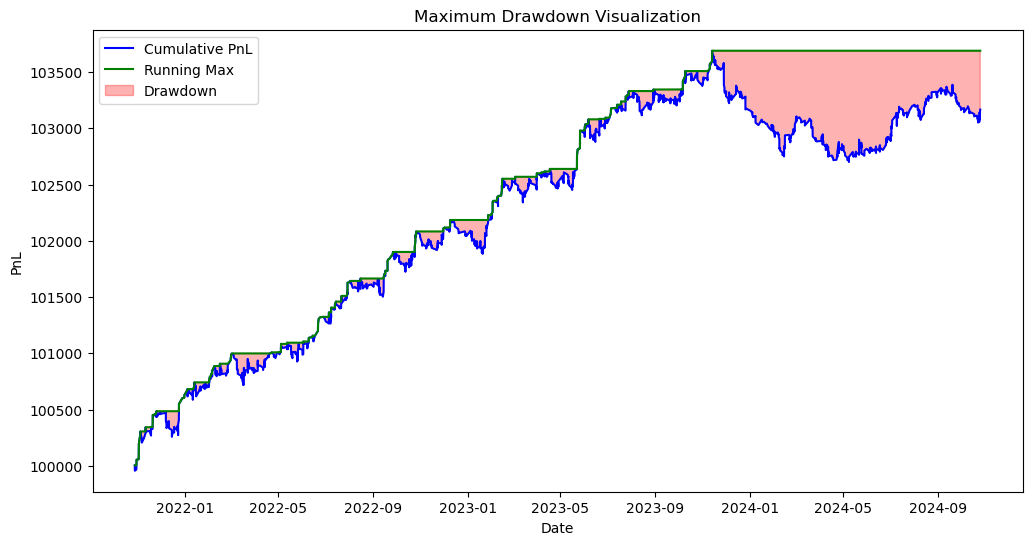

,Strategy ID,Net Profit ($),Pos Trades Total ($),Neg Trades Total ($),Profit Factor,# Winning Trades,# Total Trades,Win Ratio,R:R Ratio,Expected Profitability (also EV) ($),...,Biggest Winner ($),Biggest Loser ($),Peak Equity ($),Trough Equity ($),Max Win Streak,Max Lose Streak,Max Drawdown (%),Avg Amount Used for Trade ($),Max Amount Used for Trade ($),Avg Holding Time (min)
0,BHOD Test Strategy,3166.62,20201.29,-17034.67,1.186,1092,1920,0.569,1.112,1.649,...,48.9,-27.5,3689.935,-44.225,20,8,-0.954,9653.463,46670.85,8.58


In [30]:
metrics_table(combined_results_TSLA_3y_9am_4pm, 'BHOD Test Strategy', show_drawdown_plot = True)

We can also obtain some more granular data about the partials that the backtest took. Specifically, we can see the frequency of a stock hitting a certain TP level or SL level, and we can also see how much was gained or lost at those levels.

In [25]:
partials_table_v2(combined_results_TSLA_3y_9am_4pm)

(                                        Trade Status  Frequency  \
 Trade_Position_Adjusted                                           
 0.1                          Didn't reach tp level 1        828   
 0.5                      EOD close before tp level 1          3   
 1.0                                   Hit tp level 1       1089   
 1.1                          Didn't reach tp level 2        574   
 1.5                      EOD close before tp level 2          5   
 2.0                                   Hit tp level 2        510   
 2.1                          Didn't reach tp level 3        153   
 3.0                                   Hit tp level 3        357   
 
                          Avg Gain at TP Level  Total Gain at TP Level  
 Trade_Position_Adjusted                                                
 0.1                                -20.573273              -17034.670  
 0.5                                  5.546667                  16.640  
 1.0                      

# Conclusions for Event-Driven Backtesting
Overall, we see that this event-driven backtest for the Break High of Day strategy worked quite well. Looking at the trades this backtest took using online charting software (e.g., Trader Workstation or TradingView) reveals that our model worked exactly how it should have. All the entry conditions were met properly, and the different TP, SL, and BE exit conditions also matched what would have happened in reality.

The next step would be to expedite this process, as the time it takes to cycle through every row of data will eventually add up, especially if we want to test multiple conditions or fine-tune entries and exits. This can be done using a vectorized format, which we'll explore next.